# Graph distance benchmark
The aim of this notebook is to test several state-of-the-art methods to compare graphs to improve the assignment task (identifying whether the patient is sick or not).

To do so, we will first split randomly our dataset into 2 categories: a train and a test group. Then, we will assess the ability of each of our methods to identify whether an individual belongs to the first or the second group.

### Step 1: Dataset creation

In [1]:
import pandas as pd
import numpy as np
import random
import warnings

from scipy.linalg import eigvalsh
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from utilsData import load_data_from_patients_folder, add_mean_SUV_index
from utilsStats import build_correlation_matrix, build_graph_from_correlation_df, build_significance_matrix_for_diff, is_connected
from utilsVisual import plot_correlogram, plot_connectome
from utilsClustering import custom_spectral_clustering_on_similarity_matrix, compute_frobenius_similarity, compute_cosine_similarity, compute_spectral_distance, compute_deltaCon_distance, compute_cut_distance

random.seed(2003)
np.random.seed(2003) 

In [2]:
nb_patients_in_test = 2
nb_controls_in_test = 3

patients_data = load_data_from_patients_folder("../Data/PATIENTS")
patients_data = add_mean_SUV_index(patients_data)

controls_data = load_data_from_patients_folder("../Data/CONTROLES")
controls_data = add_mean_SUV_index(controls_data)

patients = patients_data.keys()
controls = controls_data.keys()

patients_list = list(patients)
controls_list = list(controls)

names = patients_data[list(patients)[0]].loc["name"]
names = names.to_numpy()

print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")

Loaded data for 27-53 patients.


In [3]:
patients_index_selected = [random.randint(0, len(patients_list)-1) for _ in range(nb_patients_in_test)]
controls_index_selected = [random.randint(0, len(controls_list)-1) for _ in range(nb_controls_in_test)]

test_data = dict()
test_data = {patients_list[i]: patients_data[patients_list[i]] for i in patients_index_selected} | {controls_list[i]: controls_data[controls_list[i]] for i in controls_index_selected}

patients_list = [item for i, item in enumerate(patients_list) if i not in patients_index_selected]
controls_list = [item for i, item in enumerate(controls_list) if i not in controls_index_selected]

patients_data = {patient: patients_data[patient] for patient in patients_list}
controls_data = {control: controls_data[control] for control in controls_list}

patients = patients_data.keys()
controls = controls_data.keys()
tests = test_data.keys()
tests_list = list(tests)

print(f"{len(patients_data)} patients in df, {len(patients)} in patients keys, {len(patients_list)} in patients list")
print(f"{len(controls_data)} controls in df, {len(controls)} in controls keys, {len(controls_list)} in controls list")
print(f"{len(test_data)} tests in df, {len(tests)} in tests keys, {len(tests_list)} in tests list")

25 patients in df, 25 in patients keys, 25 in patients list
50 controls in df, 50 in controls keys, 50 in controls list
5 tests in df, 5 in tests keys, 5 in tests list


### Step 2: Correlation matrices

In [4]:
correlation_matrix_patients, correlation_matrix_patients_np, correlation_matrix_patients_pval, sp_matrix_patients, sp_matrix_patients_pval, patients_graph = build_correlation_matrix(patients_data, patients, names)
correlation_matrix_controls, correlation_matrix_controls_np, correlation_matrix_controls_pval, sp_matrix_controls, sp_matrix_controls_pval, controls_graph = build_correlation_matrix(controls_data, controls, names)

In [5]:
correlation_matrix_controls_pval.describe()

,spleen,kidney_right,kidney_left,gallbladder,liver,stomach,pancreas,adrenal_gland_right,adrenal_gland_left,lung_upper_lobe_left,...,costal_cartilages,subcutaneous_fat,torso_fat,skeletal_muscle,heart_myocardium,heart_atrium_left,heart_ventricle_left,heart_atrium_right,heart_ventricle_right,pulmonary_artery
count,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,...,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02
mean,1.439961e-02,9.179367e-02,6.055083e-02,1.605200e-02,1.174729e-02,1.874220e-02,1.515703e-02,1.659674e-02,1.144233e-02,2.887125e-02,...,1.654865e-02,2.125401e-01,7.940307e-02,1.814729e-02,1.099741e-01,1.422248e-02,1.180702e-01,1.047312e-02,1.399829e-02,1.215162e-02
std,7.214843e-02,1.828096e-01,1.526029e-01,7.502793e-02,6.765294e-02,1.031817e-01,9.183222e-02,6.688089e-02,5.420195e-02,1.330081e-01,...,1.129553e-01,2.771989e-01,1.832329e-01,9.453771e-02,1.582848e-01,7.797648e-02,1.638433e-01,8.597353e-02,8.282791e-02,6.029929e-02
min,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,...,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35,2.583203e-35
25%,1.873078e-09,9.976834e-04,3.296202e-05,3.625962e-06,3.675036e-11,1.403947e-06,4.289789e-09,3.803443e-07,1.977052e-07,6.180258e-07,...,1.013531e-10,4.184452e-02,1.089631e-03,1.499111e-06,2.094624e-02,1.287280e-06,2.082279e-02,3.411378e-12,4.596683e-07,8.892087e-10
50%,3.113250e-07,8.479050e-03,6.502558e-04,6.818043e-05,1.201512e-08,1.288476e-05,7.357628e-08,7.235815e-06,3.383341e-06,1.341294e-05,...,8.274135e-09,8.232359e-02,4.712713e-03,5.023422e-05,4.684133e-02,2.022801e-05,6.108325e-02,9.033792e-09,5.847089e-06,4.044944e-07
75%,7.139857e-05,5.025749e-02,1.412639e-02,1.501423e-03,1.330614e-05,4.404756e-04,1.723716e-05,2.410922e-04,1.621701e-04,6.945676e-04,...,7.880367e-06,2.370828e-01,2.191373e-02,1.444842e-03,1.396641e-01,3.404936e-04,1.284727e-01,1.014825e-05,1.885954e-04,3.216573e-05
max,7.172085e-01,9.925365e-01,8.408608e-01,6.644197e-01,6.155997e-01,8.647799e-01,8.707194e-01,5.775640e-01,4.449141e-01,9.402121e-01,...,9.550710e-01,9.925365e-01,8.668592e-01,9.668880e-01,8.475510e-01,7.354174e-01,9.016986e-01,9.123536e-01,7.107752e-01,4.031023e-01


Before going any further, we check whether the computed Pearson coefficients are even meaningful:

In [6]:
p_value_threshold = 0.05
correlation_diff_threshold = 0.1

# Initialize a counter for non-usable coefficients
non_pvalue_patients = 0
non_pvalue_controls = 0
non_sp_patients = 0
non_sp_controls = 0
non_pvalue_patients_t = 0
non_pvalue_controls_t = 0
non_sp_patients_t = 0
non_sp_controls_t = 0
total_patients = 0
total_patients_t = 0
total_controls = 0
total_controls_t = 0

total = len(correlation_matrix_patients.columns) **2

# Iterate through the correlation matrices and check the conditions
for col1 in correlation_matrix_patients.columns:
    for col2 in correlation_matrix_patients.columns:
        # Get the Pearson correlation, p-value, and Spearman correlation
        pearson_corr = correlation_matrix_patients.loc[col1, col2]
        pearson_pval = correlation_matrix_patients_pval.loc[col1, col2]
        spearman_corr = sp_matrix_patients.loc[col1, col2]
        
        non_pvalue_patients += pearson_pval >= p_value_threshold
        non_pvalue_patients_t += pearson_pval >= p_value_threshold and abs(pearson_corr) >=0.3
        non_sp_patients += abs(pearson_corr - spearman_corr) >= correlation_diff_threshold
        non_sp_patients_t += abs(pearson_corr - spearman_corr) >= correlation_diff_threshold and abs(pearson_corr) >=0.3
        total_patients += (pearson_pval >= p_value_threshold or abs(pearson_corr - spearman_corr) >= correlation_diff_threshold)
        total_patients_t += (pearson_pval >= p_value_threshold or abs(pearson_corr - spearman_corr) >= correlation_diff_threshold) and abs(pearson_corr) >=0.3

        pearson_corr_c = correlation_matrix_controls.loc[col1, col2]
        pearson_pval_c = correlation_matrix_controls_pval.loc[col1, col2]
        spearman_corr_c = sp_matrix_controls.loc[col1, col2]
        
        non_pvalue_controls += pearson_pval_c >= p_value_threshold
        non_sp_controls += abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold
        non_pvalue_controls_t += pearson_pval_c >= p_value_threshold  and abs(pearson_corr_c) >=0.3
        non_sp_controls_t += abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold and abs(pearson_corr_c) >=0.3
        total_controls += (pearson_pval_c >= p_value_threshold or abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold) 
        total_controls_t += (pearson_pval_c >= p_value_threshold or abs(pearson_corr_c - spearman_corr_c) >= correlation_diff_threshold) and abs(pearson_corr_c) >=0.3 


print("All failures summary:")
print(f"For CONTROLES : {non_pvalue_controls} p-value failures ({non_pvalue_controls*100/total:.3}%), {non_sp_controls} spearman failures ({non_sp_controls*100/total:.3}%), {total_controls} total failures ({total_controls*100/total:.3}%)")
print(f"For PATIENTS : {non_pvalue_patients} p-value failures ({non_pvalue_patients*100/total:.3}%), {non_sp_patients} spearman failures ({non_sp_patients*100/total:.3}%), {total_patients} total failures ({total_patients*100/total:.3}%)")
print("If we only consider coefficients that are higher than 0.3: (i.e. that will remain in the connectome)")
print(f"For CONTROLES : {non_pvalue_controls_t} p-value failures ({non_pvalue_controls_t*100/total:.3}%), {non_sp_controls_t} spearman failures ({non_sp_controls_t*100/total:.3}%), {total_controls_t} total failures ({total_controls_t*100/total:.3}%)")
print(f"For PATIENTS : {non_pvalue_patients_t} p-value failures ({non_pvalue_patients_t*100/total:.3}%), {non_sp_patients_t} spearman failures ({non_sp_patients_t*100/total:.3}%), {total_patients_t} total failures ({total_patients_t*100/total:.3}%)")


All failures summary:
For CONTROLES : 1438 p-value failures (9.06%), 2018 spearman failures (12.7%), 2462 total failures (15.5%)
For PATIENTS : 2426 p-value failures (15.3%), 3030 spearman failures (19.1%), 4502 total failures (28.4%)
If we only consider coefficients that are higher than 0.3: (i.e. that will remain in the connectome)
For CONTROLES : 0 p-value failures (0.0%), 914 spearman failures (5.76%), 914 total failures (5.76%)
For PATIENTS : 938 p-value failures (5.91%), 2378 spearman failures (15.0%), 3014 total failures (19.0%)


We now compute the z-scores matrices for each of our test patients. In addition, we compute the associated p-values.

In [7]:
test_correlation_matrices = dict()
for patient in tests:
    l = dict()
    l[patient] = test_data[patient]
    c_set = set(controls)
    c_set.add(patient)
    c, c_np, cpval, s, spval, g = build_correlation_matrix(controls_data | l, c_set, names)
    z_matrix, z_p_matrix = build_significance_matrix_for_diff(correlation_matrix_controls,c, len(controls_list), Fisher=True)
    test_correlation_matrices[patient] = dict(correlation_matrix= c, correlation_matrix_np=c_np, cor_pvalue_matrix=cpval,
                                              sp_matrix=s, sp_pvalue_matrix= spval, graph=g, z_matrix=z_matrix, z_p_matrix=z_p_matrix)
    overall_zmean = z_matrix.abs().mean().mean()
    valid_coeffs = 0
    for col1 in z_p_matrix.columns:
        for col2 in z_p_matrix.columns:
            if z_p_matrix.loc[col1, col2] <= 0.05:
                valid_coeffs += 1

    print(f"For test patient {patient}: overall z-score of {overall_zmean:.3} (abs. mean) with {valid_coeffs} significant scores ({valid_coeffs*100/total:.3}%)")

For test patient 19690510: overall z-score of 0.0896 (abs. mean) with 0 significant scores (0.0%)
For test patient 19820106: overall z-score of 0.0785 (abs. mean) with 66 significant scores (0.416%)
For test patient 19580502: overall z-score of 0.0392 (abs. mean) with 0 significant scores (0.0%)
For test patient 19611129: overall z-score of 0.0374 (abs. mean) with 0 significant scores (0.0%)
For test patient 19840407: overall z-score of 0.0812 (abs. mean) with 0 significant scores (0.0%)


Overall, the results are concerning. No z-score is significant meaning that the results are absolutely not robust and we cannot from the overall z-score matrix directly disentangle the sick patients from the healthy ones. Let's have a look to the connectomes anyway.

**Sick patient:**

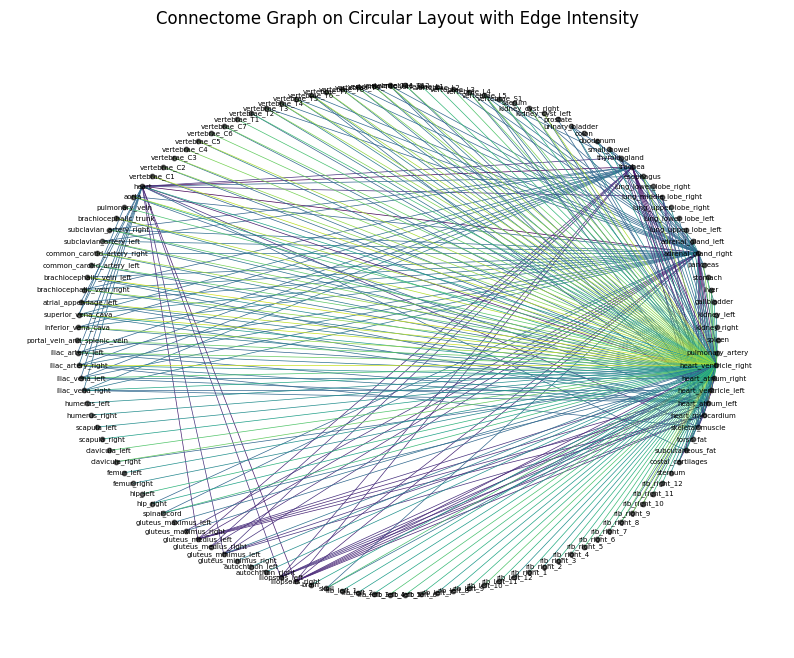

In [8]:
plot_connectome(build_graph_from_correlation_df(test_correlation_matrices[tests_list[1]]["z_matrix"], names, 0.3))

**Healthy patient:**

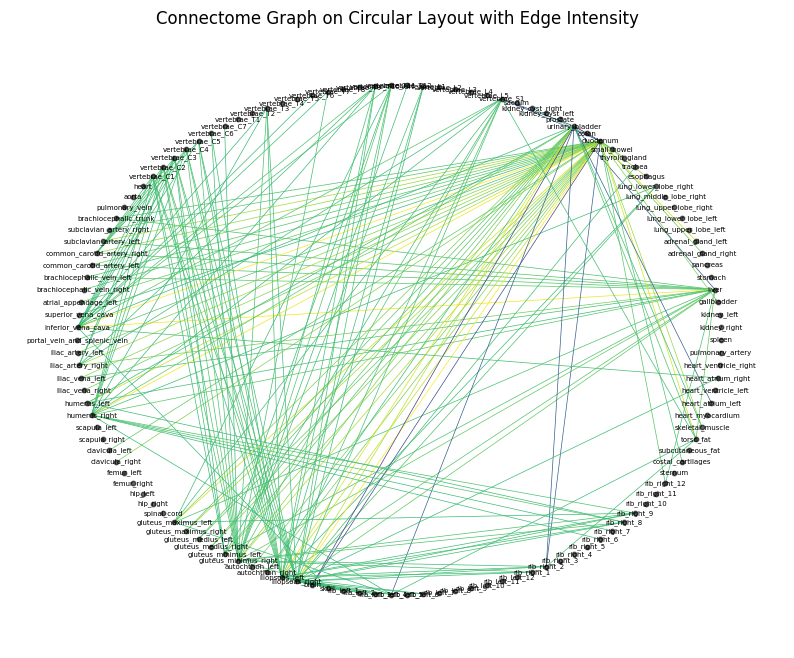

In [9]:
plot_connectome(build_graph_from_correlation_df(test_correlation_matrices[tests_list[4]]["z_matrix"], names, 0.3))

It looks like something is going on dispite the unsignificance of the z-scores. Let's persue anyway.

### Step 3: disentangle the patient types

##### Method 1: cluster on laplacian eigenvalues

In [17]:
# Compute spectral features (e.g., eigenvalues of the graph Laplacian)
def compute_spectral_features(adj_matrix):
    if is_connected(adj_matrix) is not True:
        warnings.warn("The adjacency matrix is not associated with a fully connected graph.")
    degree_matrix = np.diag(adj_matrix.sum(axis=1))
    laplacian = degree_matrix - adj_matrix
    eigenvalues = eigvalsh(laplacian)
    return eigenvalues
    
features = [
    compute_spectral_features(
        np.where(np.abs(test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy()) < 0.3, 0, 
                 test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy())
    )
    for patient_matrices in test_correlation_matrices
]

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

print("Cluster labels:", labels)

# Reduce dimensions (optional)
from sklearn.decomposition import PCA
features_reduced = PCA(n_components=2).fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_reduced)

print("Cluster labels (after PCA):", labels)

Cluster labels: [1 0 1 1 1]
Cluster labels (after PCA): [1 0 1 1 1]


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_48236/2226878542.py:4: UserWarning: The adjacency matrix is not associated with a fully connected graph.
  warnings.warn("The adjacency matrix is not associated with a fully connected graph.")


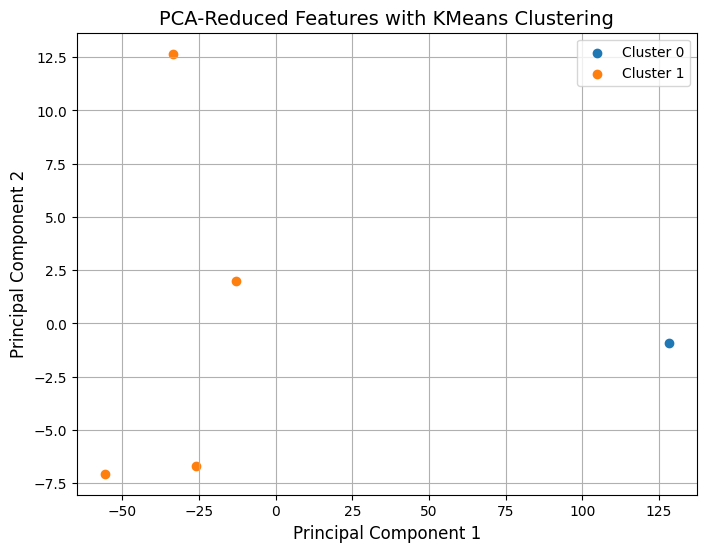

In [18]:
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(
        features_reduced[labels == label, 0],  # x-coordinates for the cluster
        features_reduced[labels == label, 1],  # y-coordinates for the cluster
        label=f"Cluster {label}"
    )

# Add labels and legend
plt.title("PCA-Reduced Features with KMeans Clustering", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Comment: This method is actually really good if and only if the graph is fully connected. Its lightweight and clusters are very well separated. Nonetheless, here, we are in a case where it breaks due to the sparsity of the graph.

##### Method 2: cluster on Frobenius norm

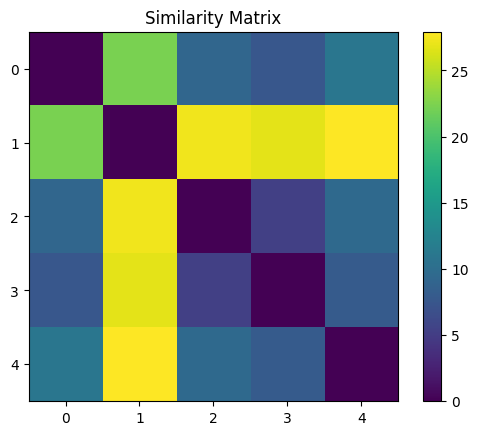

Cluster labels: [0 0 0 1 0]


: 

In [ ]:
adj_matrices = [
        np.where(np.abs(test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy()) < 0.3, 0, 
                 test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy())
    for patient_matrices in test_correlation_matrices
]
for adj in adj_matrices:
    np.fill_diagonal(adj, 0)  # Remove self-loops

print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(-compute_frobenius_similarity(adj_matrices)))

Comment: Not working properly. 

##### Method 2bis: cluster on cosine similarity

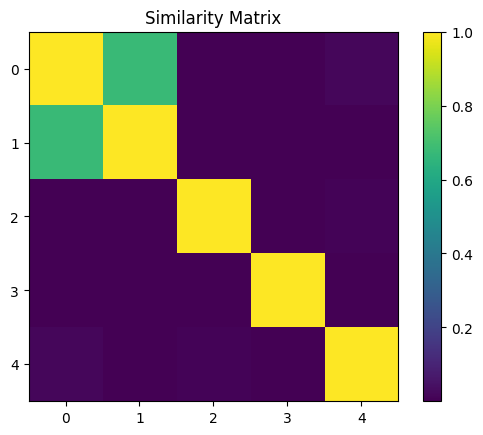

Cluster labels: [0 0 1 1 1]


In [13]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_cosine_similarity(adj_matrices) + 1e-5))

Comment: it is working but the cosine similarity in the group of healthy individuals is too low which makes the method weak.

##### Method 2ter: cluster on spectral distance

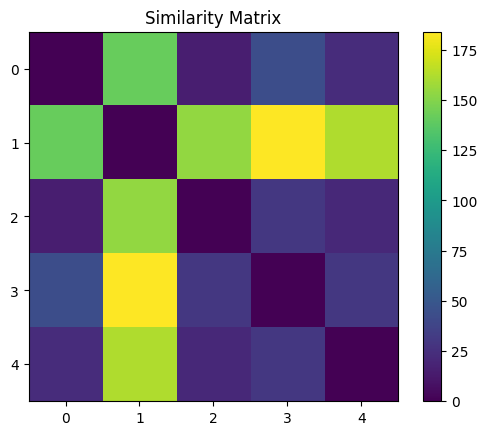

Cluster labels: [0 1 1 0 1]


In [14]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_spectral_distance(adj_matrices)))

Comment: as with the eigenvalues and the PCA, the clusters are here very well separated. The method seems good and robust.

##### Method 3: DeltaCon method

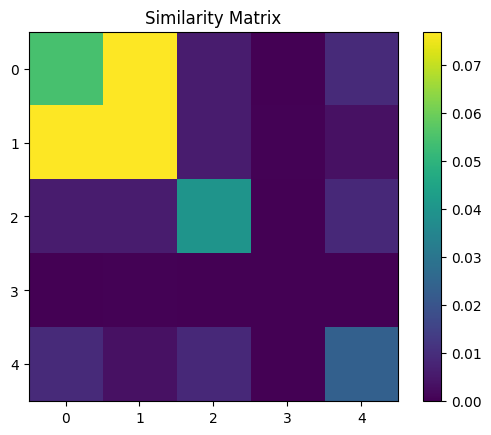

Cluster labels: [0 0 1 0 1]


In [15]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_deltaCon_distance(adj_matrices)))

Comment: The method seems good and robust.

##### Method 4: Cut distance method

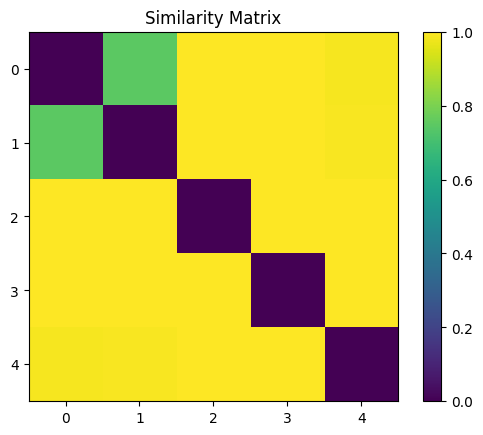

Cluster labels: [0 1 1 1 1]


In [16]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_cut_distance(adj_matrices)))

Comment: The method seems unable to detect clusters. It may be an implementation error, or it may be linked to the fact that this method is designed for unweighted graphs...